<a href="https://colab.research.google.com/github/AnnyshkaF/High-Performance-Lab/blob/main/task_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline
! pip install mpi4py

Populating the interactive namespace from numpy and matplotlib
     |████████████████████████████████| 2.5 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.2-cp37-cp37m-linux_x86_64.whl size=2183218 sha256=1b1bf1f6d6bda1008225b5cda450b38f94df8e45787fa043825360bb8ebd8296
  Stored in directory: /root/.cache/pip/wheels/62/d6/0a/91ea5f998589bc72ca3fcf425c0e364baf8536753e1cd26ea4
Successfully built mpi4py


Text(0, 0.5, 'signal, arb.units')

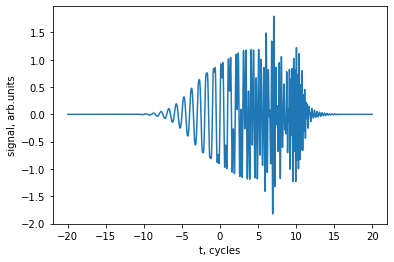

In [2]:
# generate the signal
nofts=1000
t=np.linspace(-20*2*pi, 20*2*pi, 2**14+5)
t=np.linspace(-20*2*pi, 20*2*pi, 3**9+6)
y=np.sin(t)*exp(-t**2/2/20**2)
y=y+np.sin(3*t)*exp(-(t-5*2*pi)**2/2/20**2)
y=y+np.sin(5.5*t)*exp(-(t-10*2*pi)**2/2/5**2)
y=y+np.sin(4*t)*exp(-(t-7*2*pi)**2/2/5**2)

plt.plot(t/2/pi,y)

xlabel('t, cycles')
ylabel('signal, arb.units')

Text(0, 0.5, 'Power spectrum, arb. units')

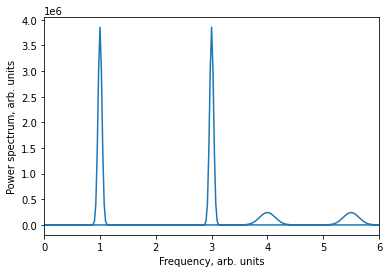

In [3]:
# Fourier spectrum
sp=fft.fft(y)
w=fft.fftfreq(len(y), d=(t[1]-t[0])/2/pi)
plot(w, abs(sp)**2)
xlim(0,6)
xlabel('Frequency, arb. units')
ylabel('Power spectrum, arb. units')

(0.0, 10.0)

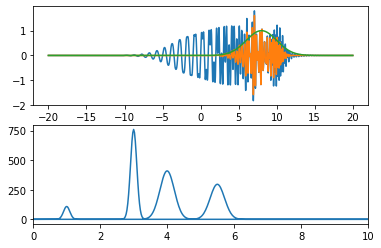

In [4]:
# windowed Fourier transform (Gabor transform, spectrogram)

window_width=2.0*2*pi
window_position=8*2*pi
window_function=exp(-(t-window_position)**2/2/window_width**2)

y_window=y * window_function

subplot(211)
plot(t/2/pi, y)
plot(t/2/pi, y_window)
plot(t/2/pi, window_function)

sp = fft.fft(y_window)
w=fft.fftfreq(len(y), d=(t[1]-t[0])/2/pi)
subplot(212)
plot(w, abs(sp))
xlim(0, 10)
# now do the same for different window positions and plot 2D graph
# x_axis is window position
# y_axis is frequency
# color axis represents the power spectrum

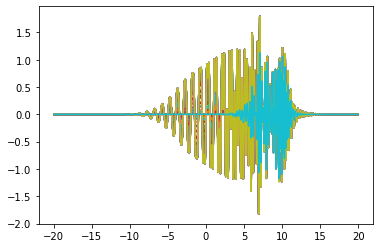

In [5]:
for i in range(-10,10,1):
  window_width=2.0*2*pi
  window_position=i*2*pi
  window_function=exp(-(t-window_position)**2/2/window_width**2)

  y_window=y * window_function

  plot(t/2/pi, y)
  plot(t/2/pi, y_window)

In [27]:
%%writefile test.py
#try to parralell
from mpi4py import MPI
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from random import random

comm = MPI.COMM_WORLD #create a communicator
rank = comm.Get_rank() #rank of executing process
size = comm.Get_size() #gives number of ranks in comm
print("my rank is ", rank)

nofts=1000
t=np.linspace(-20*2*np.pi, 20*2*np.pi, 2**14+5)
t=np.linspace(-20*2*np.pi, 20*2*np.pi, 3**9+6)
y=np.sin(t)*np.exp(-t**2/2/20**2)
y=y+np.sin(3*t)*np.exp(-(t-5*2*np.pi)**2/2/20**2)
y=y+np.sin(5.5*t)*np.exp(-(t-10*2*np.pi)**2/2/5**2)
y=y+np.sin(4*t)*np.exp(-(t-7*2*np.pi)**2/2/5**2)


nwindowsteps = 1000
t1 = MPI.Wtime()
t_window = np.linspace(-20*2*np.pi, 20*2*np.pi, nwindowsteps)
tw_list = np.array_split(t_window,size)[rank]
numDataPerRank = int((t_window.size)/size)


window_width=2.0*2*np.pi
specgram = np.empty([len(t), len(t_window)])

for n, t_w in enumerate(t_window):
  window_position = t_w
  window_function = np.exp(-(t-window_position)**2/2/window_width**2)
  y_window = y * window_function
  #plot(y_window)
  specgram[:,n] = abs(np.fft.fft(y_window))

t2 = MPI.Wtime()        
#comm.Gather(sendbuf, recvbuf, root=0)
recieved_x = comm.gather(specgram,root=0) 

if rank == 0:
    recv_x = np.hstack(specgram) 
    #plt.imshow(specgram) #, aspect='auto', origin='lower', extent=[min(t)/2/pi, max(t)/2/pi, w[0], 2*w[int(len(w)/2/100)]])
    #plt.colorbar()
    #plt.ylim(0, 300)

Overwriting test.py


In [26]:
! mpirun --allow-run-as-root -n 1 python test.py

my rank is  0


In [28]:
timeit_arr = []
for i in range(1, 8):
    timeit_value = %timeit -o -n 1 ! mpirun --allow-run-as-root -n {i} python test.py
    timeit_arr.append(sum(timeit_value.all_runs)/len(timeit_value.all_runs))
    print(i)

my rank is  0
my rank is  0
my rank is  0
my rank is  0
my rank is  0
1 loop, best of 5: 8.76 s per loop
1
my rank is  0
my rank is  1
my rank is  0
my rank is  1
my rank is  0
my rank is  1
my rank is  0
my rank is  1
my rank is  1
my rank is  0
1 loop, best of 5: 14.2 s per loop
2
my rank is  1
my rank is  2
my rank is  0
my rank is  0
my rank is  1
my rank is  2
my rank is  0
my rank is  1
my rank is  2
my rank is  2
my rank is  1
my rank is  0
my rank is  1
my rank is  0
my rank is  2
1 loop, best of 5: 20.7 s per loop
3
my rank is  0
my rank is  3
my rank is  1
my rank is  2
my rank is  2
my rank is  1
my rank is  0
my rank is  3
my rank is  1
my rank is  2
my rank is  3
my rank is  0
my rank is  1
my rank is  3
my rank is  0
my rank is  2
my rank is  0
my rank is  2
my rank is  1
my rank is  3
1 loop, best of 5: 28.1 s per loop
4
my rank is  2
my rank is  0
my rank is  1
my rank is  4
my rank is  3
my rank is  1
my rank is  0
my rank is  2
my rank is  4
my rank is  3
my rank is  

Text(0.5, 0.98, 'Speedup vs Np')

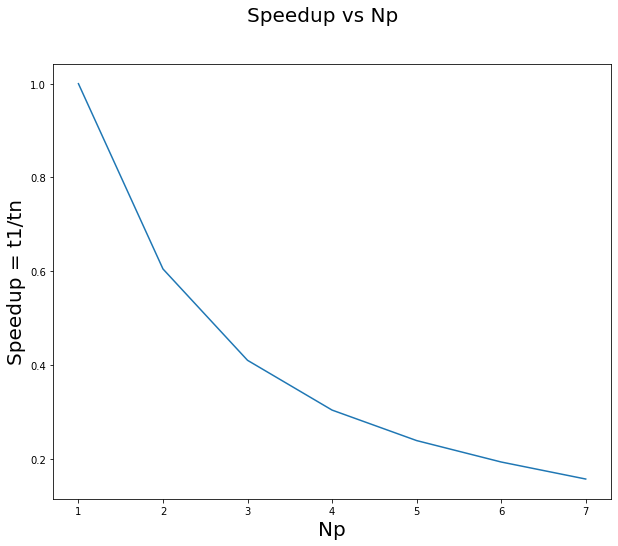

In [29]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

t1 = timeit_arr[0]
def SpeedUp(tn):
    return t1/tn
Speedup = list(map(SpeedUp, timeit_arr))
plt.figure(figsize=(10, 8))
num_of_processes = np.linspace(1, len(timeit_arr), len(timeit_arr))
plt.plot(num_of_processes, Speedup)
plt.xlabel('Np', fontsize = 20)
plt.ylabel('Speedup = t1/tn', fontsize = 20)
plt.suptitle('Speedup vs Np', fontsize = 20)